## Extractive Summarization - Pytorch

In this notebook, we provide an implementation for training an extractive text summarization model. The overall goal is to "score" each sentence in a passage where the score represents the likelihood that the sentence belongs in a summary.


## Dataset

We will use the CNN/Dailymail dataset (contains articles and human written highlights) which has been preprocessed in the following way

- Each sentence in each article (extracted using a large Spacy LM) is assigned a label (0: not in summary, 1: in summary). Since CNN/DailyMail highlights dont contain exact extracts, the label is generatedd based on max Rogue score between sentence and each sentence in highlights. See data preprocesssing notebook for details.
- Data is undersampled to reduce class imbalance 

## Problem Formulation and Model 

We treat this as a sentence classification problem where the goal is to classify each sentence in a document as belonging to a summary or not, given the document (or portions of the document) 

- Model Input: a sentence, and the entire document 
- Model Output: A score representing likelihood of belonging in the summary or not. 

## Implementation 

- We use sentence bert models to get representations for our text. We use the smallest model (sentence-transformers/paraphrase-MiniLM-L3-v2), but this can be replaced by a larger more accurate model. See the list of sentence bert pretrained  [models](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models).
- Representations for sentence and document are concatenated and fed to a Dense layer and then predictions.

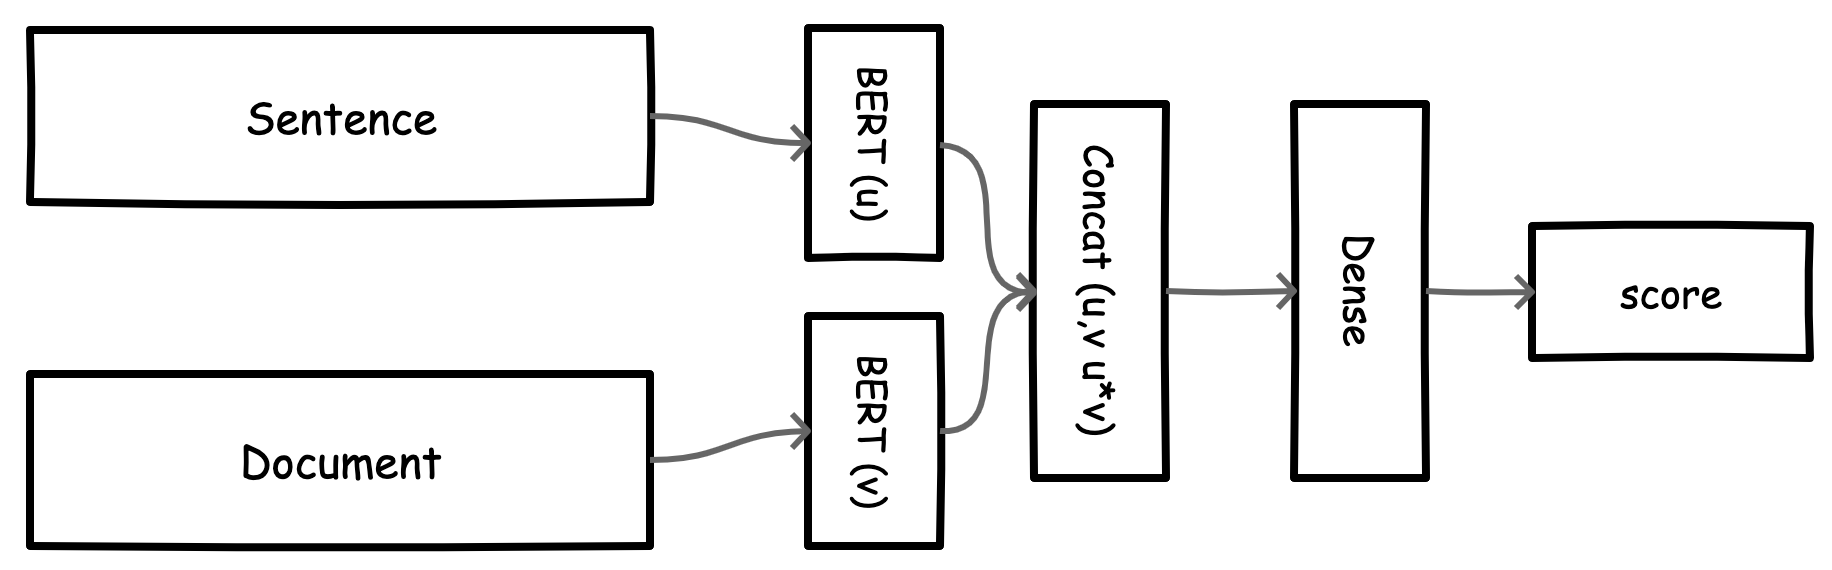

In [ ]:
!pip install -q transformers  rouge-score  

     |████████████████████████████████| 2.6 MB 7.0 MB/s 
     |████████████████████████████████| 636 kB 78.8 MB/s 
     |████████████████████████████████| 895 kB 71.4 MB/s 
     |████████████████████████████████| 3.3 MB 73.7 MB/s 


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name) 


Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os 
  
sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/" # location to store and load models 

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05 

# load dataframes containining preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json(sum_dir + "data/train_bdf.json")
test_df = pd.read_json(sum_dir +"data/test_bdf.json") 
print( "Train, test shape", train_df.shape, test_df.shape)

Train, test shape (687975, 3) (33702, 3)


## Create a Data Loader Class 

- Create a dataloader class that yields sentences and documentss and labels.

In [ ]:

# Create a Data Loader Class
class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len



training_set = CNNDailyMailData(train_df, tokenizer, MAX_LEN)
testing_set = CNNDailyMailData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)        

## Build Model 

- Build model based on sentence Bert pretrained models.

In [ ]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Note that different sentence transformer models may have different in_feature sizes
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)   
        
        pooler = self.pre_classifier(concat_features) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 1000
EPOCHS = 3 
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

0/687975 - Steps. Acc -> 25.0 Loss -> 0.6930302381515503
4000/687975 - Steps. Acc -> 66.53346653346654 Loss -> 0.6194909393459886
8000/687975 - Steps. Acc -> 67.44127936031984 Loss -> 0.6050186359334266
12000/687975 - Steps. Acc -> 67.8857047650783 Loss -> 0.5980613226296305
16000/687975 - Steps. Acc -> 67.9705073731567 Loss -> 0.5955710325188054
20000/687975 - Steps. Acc -> 68.16636672665467 Loss -> 0.5926978352176645
24000/687975 - Steps. Acc -> 68.46775537410431 Loss -> 0.588505676601295
28000/687975 - Steps. Acc -> 68.82945293529495 Loss -> 0.5853846278767929
32000/687975 - Steps. Acc -> 69.0538682664667 Loss -> 0.5833127150420785
36000/687975 - Steps. Acc -> 69.17564715031664 Loss -> 0.5818237721706454
40000/687975 - Steps. Acc -> 69.28557144285571 Loss -> 0.5802682216634286
44000/687975 - Steps. Acc -> 69.4005090446323 Loss -> 0.5791895490279578
48000/687975 - Steps. Acc -> 69.48587617698526 Loss -> 0.5782784935251175
52000/687975 - Steps. Acc -> 69.60041535266518 Loss -> 0.57676

0it [00:00, ?it/s]

0/687975 - Steps. Acc -> 100.0 Loss -> 0.2609235644340515
4000/687975 - Steps. Acc -> 75.14985014985015 Loss -> 0.4992662792751839
8000/687975 - Steps. Acc -> 76.4367816091954 Loss -> 0.4873348221933094
12000/687975 - Steps. Acc -> 76.61612795734754 Loss -> 0.48745297585135794
16000/687975 - Steps. Acc -> 76.51837040739815 Loss -> 0.4868888769650744
20000/687975 - Steps. Acc -> 76.45970805838832 Loss -> 0.48751182371064783
24000/687975 - Steps. Acc -> 76.50391601399767 Loss -> 0.4861464867229597
28000/687975 - Steps. Acc -> 76.4533638051707 Loss -> 0.48590784799400705
32000/687975 - Steps. Acc -> 76.4623172103487 Loss -> 0.48543691794670735
36000/687975 - Steps. Acc -> 76.4248416842573 Loss -> 0.48655522819026953
40000/687975 - Steps. Acc -> 76.46485351464854 Loss -> 0.48613485556202746
44000/687975 - Steps. Acc -> 76.50895373147895 Loss -> 0.48534206101739774
48000/687975 - Steps. Acc -> 76.49987501041579 Loss -> 0.48456995443994055
52000/687975 - Steps. Acc -> 76.50949926928698 Loss 

0it [00:00, ?it/s]

0/687975 - Steps. Acc -> 100.0 Loss -> 0.22294992208480835
4000/687975 - Steps. Acc -> 79.32067932067932 Loss -> 0.4425728789174354
8000/687975 - Steps. Acc -> 79.16041979010495 Loss -> 0.44066531267920056
12000/687975 - Steps. Acc -> 78.74875041652783 Loss -> 0.4424510123031273
16000/687975 - Steps. Acc -> 78.84278930267433 Loss -> 0.4408871670647193
20000/687975 - Steps. Acc -> 78.9242151569686 Loss -> 0.43947605636001374
24000/687975 - Steps. Acc -> 79.03682719546742 Loss -> 0.4382052738806135
28000/687975 - Steps. Acc -> 79.2243965147836 Loss -> 0.4373155197887174
32000/687975 - Steps. Acc -> 79.27446569178852 Loss -> 0.4374471848562626
36000/687975 - Steps. Acc -> 79.24119542273081 Loss -> 0.4376471848241052
40000/687975 - Steps. Acc -> 79.34706529347065 Loss -> 0.437297835472646
44000/687975 - Steps. Acc -> 79.40641759840014 Loss -> 0.43728001014416773
48000/687975 - Steps. Acc -> 79.31422381468211 Loss -> 0.4378643236297246
52000/687975 - Steps. Acc -> 79.33620490731482 Loss -> 

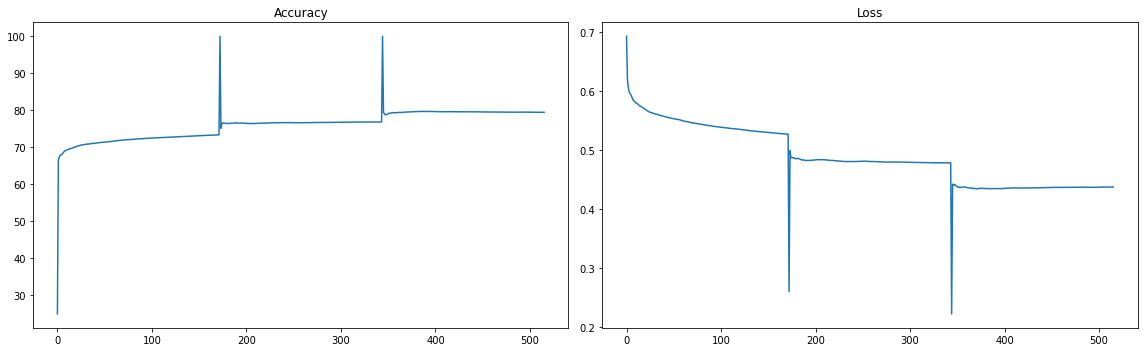

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

## Validation on Test Set

In [ ]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): 
            
            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float)  

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%print_n_steps==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

             
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
acc = validate_model(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

Hint: Try a larger sentence embedding [pretrained model](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models) to improve overall train/test accuracy. 

## Save Model

In [ ]:
import os 

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/minilm_bal_exsum.pth")
!gsutil cp -r models $sum_dir

# Conclusions 

The approach described above is a relatively untuned baseline. There are multiple opportunities for improvement. We can discuss a few below:

## Handling Data Imbalance :  
Given the nature of the task (selecting a small subset of sentences in a lengthy document), for most of the sentences we get from our training dataset, the vast majority will not belong to a summary. Class imbalance! 
 In this work, we used undersampling as a baseline strategy to handle class imbalance. A limitation of this approach is that we use a relatively small part of the total available data. We can explore other approaches that enable us to use most or all of our data. Weighted loss functions are recommended! 


## Sentencizer: 
Constructing our training dataset examples depends on the use of a sentencizer that converts documents to sentences which are used in constructing   training examples.  Similarly, at test time, a sentencizer is used to convert documents to sentences which are scored and used in the summary. A poor sentencizer (e.g. one that clips sentences midway) will make for summaries that are hard to read/follow. We found that using a large Spacy language model was a good starting point (the small model is not recommended). Bonus points for investing in a custom sentencizer that incorporates domain knowledge for your problem space. 


## Sentence and Document Representations: 

In this baseline, we use the Sentence Bert small model in deriving representations for sentences and documents. Other methods ( e.g. larger models) etc may provide improved results.  One thing to note is that while BERT based models will yield a representation for an arbitrarily sized document, in practice they are only using the first n tokens (where = maximum sequence length for the model which is usually 512 tokens). We also found that fine tuning the underlying BERT model on the extractive summarization task yielded significantly better results than using the BERT model as a simple feature extractor.


## Tuning Hyperparameters: 

A project like this has many obvious and non-obvious hyperparameters that could all be tuned. Beyond the choice of BERT model architecture and training parameters, we could also tune things like the label generation strategy, sentencizer, minimum sentence length to use in training/inference etc.
